In [1]:
import time
import os
import pickle
import numpy as np
import torch, torch_geometric.transforms as T, torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

from torch_geometric.loader import DataLoader
from torch_geometric.nn import MetaLayer

import tensorflow as tf

import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    auc,
    average_precision_score,
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
)

import cancernet
from cancernet.arch import PNet
from cancernet.util import ProgressBar, InMemoryLogger, get_roc
from cancernet import PnetDataSet, ReactomeNetwork
from cancernet.dataset import get_layer_maps

enable_pytorch_train = True

2022-10-12 21:55:26.782215: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-12 21:55:26.991836: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-12 21:55:27.028009: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-12 21:55:27.797079: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

# Load Reactome Data

In [2]:
reactome_kws = dict(
    reactome_base_dir=os.path.join("data", "reactome"),
    relations_file_name="ReactomePathwaysRelation.txt",
    pathway_names_file_name="ReactomePathways.txt",
    pathway_genes_file_name="ReactomePathways.gmt",
)
reactome = ReactomeNetwork(reactome_kws)

prostate_root = os.path.join("data", "prostate")
dataset = PnetDataSet(
    root=prostate_root,
    name="prostate_graph_humanbase",
    edge_tol=0.5,
    pre_transform=T.Compose(
        [T.GCNNorm(add_self_loops=False), T.ToSparseTensor(remove_edge_index=False)]
    ),
)

# loads the train/valid/test split from pnet
splits_root = os.path.join(prostate_root, "splits")
dataset.split_index_by_file(
    train_fp=os.path.join(splits_root, "training_set_0.csv"),
    valid_fp=os.path.join(splits_root, "validation_set.csv"),
    test_fp=os.path.join(splits_root, "test_set.csv"),
)

In [3]:
maps = get_layer_maps(
    genes=[g for g in dataset.node_index],
    reactome=reactome,
    n_levels=2,
    direction="root_to_leaf",
    add_unk_genes=False,
    verbose=True,
)

layer # 0
pathways 146
genes 10621
filtered_map (9054, 0)
filtered_map (9054, 0)
filtered_map (9054, 0)
layer # 1
pathways 26
genes 147
filtered_map (146, 0)
filtered_map (146, 0)
filtered_map (146, 0)
layer # 2
pathways 1
genes 26
filtered_map (26, 0)
filtered_map (26, 0)
filtered_map (26, 0)


In [4]:
maps[0].sum(axis=0).sort_values(ascending=False).head(20)

R-HSA-597592     797.0
R-HSA-73857      731.0
R-HSA-372790     524.0
R-HSA-168249     516.0
R-HSA-1280218    383.0
R-HSA-199991     382.0
R-HSA-556833     366.0
R-HSA-1280215    339.0
R-HSA-422475     285.0
R-HSA-9006934    268.0
R-HSA-5663202    245.0
R-HSA-194315     218.0
R-HSA-5663205    206.0
R-HSA-2262752    186.0
R-HSA-9006925    180.0
R-HSA-5683057    168.0
R-HSA-71291      165.0
R-HSA-195721     165.0
R-HSA-72203      163.0
R-HSA-71387      161.0
dtype: float64

In [5]:
# use only top subsys
#n_top = 12
#maps[0] = maps[0][maps[0].sum(axis=0).sort_values(ascending=False).head(n_top).index]
maps[0].head()

,R-HSA-109581,R-HSA-112307,R-HSA-112315,R-HSA-1181150,R-HSA-1187000,R-HSA-1268020,R-HSA-1280215,R-HSA-1280218,R-HSA-1296071,R-HSA-1362409,...,R-HSA-9006927,R-HSA-9006931,R-HSA-9006934,R-HSA-9006936,R-HSA-9033241,R-HSA-917937,R-HSA-927802,R-HSA-977225,R-HSA-983231,R-HSA-983712
A1CF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAAS,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AACS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AADAC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AADACL2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
maps[0].shape

(9054, 146)

In [7]:
maps[0].sum(axis=0).sort_values(ascending=False)

R-HSA-597592     797.0
R-HSA-73857      731.0
R-HSA-372790     524.0
R-HSA-168249     516.0
R-HSA-1280218    383.0
                 ...  
R-HSA-75944        2.0
R-HSA-5676934      2.0
R-HSA-8981607      1.0
R-HSA-1566977      1.0
R-HSA-71737        1.0
Length: 146, dtype: float64

# Train

Set up hyperparameters and random seed.

In [8]:
# try to ensure reproducibility
pl.seed_everything(42, workers=True)

n_epochs = 500
batch_size = 10
lr = 0.001

Global seed set to 42


Prepare data.

In [9]:
train_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.train_idx),
)
valid_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.valid_idx),
)


Create and train model.

In [10]:

t0 = time.time()
model = PNet(
    layers=maps,
    num_genes=maps[0].shape[0], # 9054
    num_features=3,
)
logger = InMemoryLogger()
early_stop_callback = EarlyStopping(
    monitor="val_loss", min_delta=0.00, patience=100, verbose=False, mode="min"
)
checkpoint_callback = ModelCheckpoint(
    dirpath="model_ckpts",
    monitor="val_loss",
    save_top_k=1,
    filename="bestmodel_pnet",
    mode="min",
)
bestmodel_file = os.path.join("model_ckpts", "bestmodel_pnet.ckpt")
if os.path.isfile(bestmodel_file):
    os.remove(bestmodel_file)

# XXX this cannot be fully deterministic on GPU because
# XXX scatter_add_cuda_kernel does not have a deterministic implementation!
trainer = pl.Trainer(
    accelerator="auto",
    max_epochs=n_epochs,
    callbacks=[ProgressBar(), early_stop_callback, checkpoint_callback],
    logger=logger,
    # deterministic=True,
)
if enable_pytorch_train:
    trainer.fit(model, train_loader, valid_loader)
    print(f"Training took {time.time() - t0:.1f} seconds.")

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/mnt/home/zzhang/anaconda3/envs/cancernet/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:611: UserWarning: Checkpoint directory /mnt/ceph/users/zzhang/cancer-net/demos/model_ckpts exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type       | Params
-----------------------------------------
0 | criterion | BCELoss    | 0     
1 | network   | ModuleList | 47.7 K
-----------------------------------------
47.7 K    Trainable params
0         Non-trainable params
47.7 K    Total params
0.191     Total estimated model params size (MB)
/mnt/home/zzhang/anaconda3/envs/cancernet/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataload

Training:   0%|          | 0/500 [00:00<?, ?it/s]

Training took 269.5 seconds.


Visualize training trajectory.

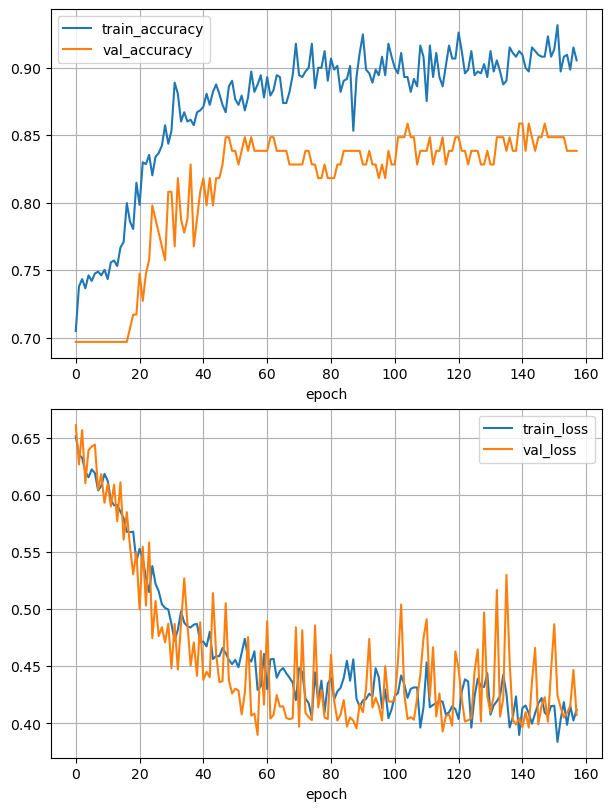

In [11]:
if enable_pytorch_train:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8), constrained_layout=True)
    logger.metrics_df.plot("epoch", ["train_accuracy", "val_accuracy"], ax=ax1)
    ax1.grid()

    logger.metrics_df.plot("epoch", ["train_loss", "val_loss"], ax=ax2)
    ax2.grid()

Calculate and show ROC and AUC.

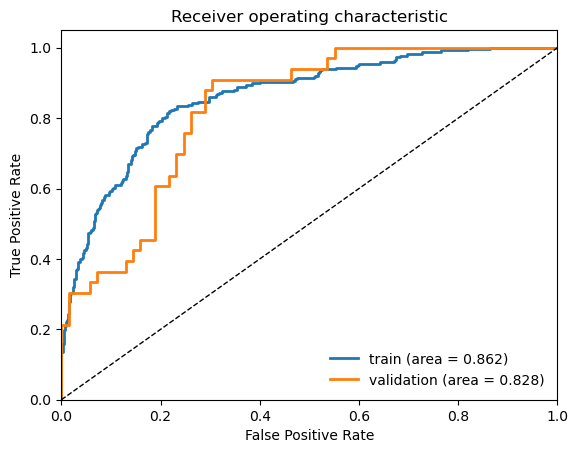

In [12]:
bestmodel_file = os.path.join("model_ckpts", "bestmodel_pnet.ckpt")
model = PNet.load_from_checkpoint(bestmodel_file)
fpr_train, tpr_train, train_auc, _, _ = get_roc(model, train_loader)
fpr_valid, tpr_valid, valid_auc, _, _ = get_roc(model, valid_loader)

fig, ax = plt.subplots()
ax.plot(fpr_train, tpr_train, lw=2, label="train (area = %0.3f)" % train_auc)
ax.plot(fpr_valid, tpr_valid, lw=2, label="validation (area = %0.3f)" % valid_auc)
ax.plot([0, 1], [0, 1], color="black", lw=1, linestyle="--")
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.set_title("Receiver operating characteristic")
ax.legend(loc="lower right", frameon=False)

Check performance on test set.

In [13]:
test_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.test_idx),
    drop_last=False,
)
fpr_test, tpr_test, test_auc, ys, outs = get_roc(model, test_loader)

print("accuracy", accuracy_score(ys, outs[:, 1] > 0.5))
print("auc", test_auc)
print("aupr", average_precision_score(ys, outs[:, 1]))
print("f1", f1_score(ys, outs[:, 1] > 0.5))
print("precision", precision_score(ys, outs[:, 1] > 0.5))
print("recall", recall_score(ys, outs[:, 1] > 0.5))

accuracy 0.3333333333333333
auc 0.8036332179930796
aupr 0.6763816967172688
f1 0.5
precision 0.3333333333333333
recall 1.0


# Load TF model

In [14]:
import importlib
from cancernet.pnet.model.model_factory import get_model
from cancernet.pnet.model.nn import Model
from cancernet.pnet.model.builders.builders_utils import get_map_from_layer, get_layer_maps
from cancernet.pnet.data.data_access import Data

params_file = '.onsplit_average_reg_10_tanh_large_testing'
params_file_full = "cancernet.pnet.train.params.P1000.pnet" + params_file
params = importlib.import_module(params_file_full)

# manually adjusted P-net model params
n_hidden_layers = 2
params.models[0]['params']['model_params']['n_hidden_layers'] = n_hidden_layers
params.models[0]['params']['model_params']['w_reg'] = [0.001] * (n_hidden_layers+1)
params.models[0]['params']['model_params']['w_reg_outcomes'] = [0.001] * (n_hidden_layers+1)
params.models[0]['params']['model_params']['dropout'] = [0.5]+[0.1] * (n_hidden_layers+1)
params.models[0]['params']['model_params']['loss_weights'] = [2] * (n_hidden_layers-6) + [2, 7, 20, 54, 148, 400]
# new input genes
params.models[0]['params']['model_params']['data_params']['params']['selected_genes'] = \
    'tcga_prostate_expressed_genes_and_cancer_genes.csvmatched_pyg.csv'
# change molecular data type order to match PyG dataset
params.models[0]['params']['model_params']['data_params']['params']['data_type'] = \
 ['mut_important', 'cnv_amp', 'cnv_del']

data = Data(**params.data[0])

x_train, x_validate_, x_test_, y_train, y_validate_, y_test_, info_train, info_validate_, info_test_, cols = data.get_train_validate_test()
print(x_train.shape)

# poor fix for random gene order now
#x_train = np.load('x_train.npy')
#y_train = np.load('y_train.npy')
#x_test_ = np.load('x_test_.npy')
#y_test_ = np.load('y_test_.npy')


model_build_fn = Model(**params.models[0]['params'])
ret = model_build_fn.build_fn(**model_build_fn.model_params)
tf_model, feature_names, reactome_map = ret
tf_model.load_weights("pnet_tf_mod.h5")


/mnt/ceph/users/zzhang/cancer-net/cancernet/pnet/data/prostate_paper/data_reader.py:69: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x = x.loc[:, intersect]
/mnt/ceph/users/zzhang/cancer-net/cancernet/pnet/data/prostate_paper/data_reader.py:69: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x = x.loc[:, intersect]
/mnt/ceph/users/zzhang/cancer-net/cancernet/pnet/data/prostate_paper/data_reader.py:69: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x = x.loc[:, intersect]


(807, 27162)
{'id': 'ALL', 'type': 'prostate_paper', 'params': {'data_type': ['mut_important', 'cnv_amp', 'cnv_del'], 'drop_AR': False, 'cnv_levels': 3, 'mut_binary': True, 'balanced_data': False, 'combine_type': 'union', 'use_coding_genes_only': True, 'selected_genes': 'tcga_prostate_expressed_genes_and_cancer_genes.csvmatched_pyg.csv', 'training_split': 0}}
n_hidden_layers 2


/mnt/ceph/users/zzhang/cancer-net/cancernet/pnet/data/prostate_paper/data_reader.py:69: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x = x.loc[:, intersect]
/mnt/ceph/users/zzhang/cancer-net/cancernet/pnet/data/prostate_paper/data_reader.py:69: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x = x.loc[:, intersect]
/mnt/ceph/users/zzhang/cancer-net/cancernet/pnet/data/prostate_paper/data_reader.py:69: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  x = x.loc[:, intersect]


(1011, 27162)
(1011, 1)
(1011,)
(27162,)
input dimension 27162 self.units 9054
n_inputs_per_node 3
self.kernel_initializer <keras.regularizers.L2 object at 0x1553df65ca00> <keras.initializers.initializers_v2.LecunUniform object at 0x1553df65c760> <keras.regularizers.L2 object at 0x1553df65ca00>
input dimensions (None, 27162)


2022-10-12 22:00:15.151021: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64:/mnt/sw/nix/store/f0ycdncw8dw4wlicnzm74lgv9c51rlg4-openblas-0.3.20/lib
2022-10-12 22:00:15.151065: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-10-12 22:00:15.151360: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX51

pathways 146
genes 10621
pathways 26
genes 147
pathways 1
genes 26
original dropout [0.5, 0.1, 0.1, 0.1]
dropout [1, 2] [0.5, 0.1, 0.1, 0.1] [0.001, 0.001, 0.001]
layer 0, dropout  0.1 w_reg 0.001
layer 1, dropout  0.1 w_reg 0.001
Compiling...
loss_weights [2, 7, 20, 54, 148, 400]
[<keras.engine.input_layer.InputLayer object at 0x1553df869130>, <cancernet.pnet.model.layers_custom.Diagonal object at 0x1553df65ceb0>, <keras.layers.regularization.dropout.Dropout object at 0x1553df5e0640>, <cancernet.pnet.model.layers_custom.SparseTF object at 0x1553df2fab50>, <keras.layers.regularization.dropout.Dropout object at 0x1553df2ef6a0>, <cancernet.pnet.model.layers_custom.SparseTF object at 0x1553df2e50d0>, <keras.layers.core.dense.Dense object at 0x1553df5e00a0>, <keras.layers.core.dense.Dense object at 0x1553df5e0220>, <keras.layers.core.dense.Dense object at 0x1553df2e5820>, <keras.layers.core.activation.Activation object at 0x1553df5e0b20>, <keras.layers.core.activation.Activation object at 

In [15]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, average_precision_score, f1_score, accuracy_score, \
    precision_score, recall_score

y_hat = tf_model.predict(x_test_)
print([y.shape for y in y_hat])

ys = y_test_.flatten()
outs = y_hat[-1]

fpr_valid, tpr_valid, _ = roc_curve(ys, outs)
test_auc = auc(fpr_valid, tpr_valid)

print('accuracy', accuracy_score(ys, outs>0.5))
print('auc', test_auc)
print('aupr', average_precision_score(ys, outs))
print('f1', f1_score(ys, outs>0.5))
print('precision', precision_score(ys, outs>0.5))
print('recall', recall_score(ys, outs>0.5))

input dimensions (None, 27162)
4/4 [==============================] - 0s 4ms/step
[(102, 1), (102, 1), (102, 1)]
accuracy 0.8921568627450981
auc 0.9563148788927335
aupr 0.922809400415429
f1 0.8358208955223881
precision 0.8484848484848485
recall 0.8235294117647058


In [16]:
import pickle
with open("pnet_tf_weights.pkl", "rb") as f:
    tf_state_dict = pickle.load(f)
{k:[v_.shape for v_ in v] for k,v in tf_state_dict.items()}

{'inputs': [],
 'h0': [(27162,), (9054,)],
 'dropout_0': [],
 'h1': [(11124,), (146,)],
 'dropout_1': [],
 'h2': [(147,), (26,)],
 'o_linear1': [(9054, 1), (1,)],
 'o_linear2': [(146, 1), (1,)],
 'o_linear3': [(26, 1), (1,)],
 'o1': [],
 'o2': [],
 'o3': []}

# Compare TF and PyTorch P-Net Models

In [17]:
state_dict = model.state_dict()

In [18]:
{k:v.shape for k,v in state_dict.items()}

{'network.0.weights': torch.Size([9054, 3]),
 'network.0.bias': torch.Size([9054]),
 'network.3.weights': torch.Size([11124]),
 'network.3.bias': torch.Size([146]),
 'network.3.nonzero_indices': torch.Size([11124, 2]),
 'network.6.weights': torch.Size([147]),
 'network.6.bias': torch.Size([26]),
 'network.6.nonzero_indices': torch.Size([147, 2]),
 'network.9.weight': torch.Size([1, 26]),
 'network.9.bias': torch.Size([1])}

In [19]:
state_dict['network.0.weights'].copy_(torch.Tensor(np.reshape(tf_state_dict['h0'][0], (9054, 3))))
state_dict['network.0.bias'].copy_(torch.Tensor(np.reshape(tf_state_dict['h0'][1], (9054,))))
state_dict['network.3.weights'].copy_(torch.Tensor(tf_state_dict['h1'][0]))
state_dict['network.3.bias'].copy_(torch.Tensor(tf_state_dict['h1'][1]))
state_dict['network.6.weights'].copy_(torch.Tensor(tf_state_dict['h2'][0]))
state_dict['network.6.bias'].copy_(torch.Tensor(tf_state_dict['h2'][1]))
state_dict['network.9.weight'].copy_(torch.Tensor(tf_state_dict['o_linear3'][0].squeeze()))
state_dict['network.9.bias'].copy_(torch.Tensor(tf_state_dict['o_linear3'][1]))

tensor([-0.0220])

In [20]:
model.load_state_dict(state_dict=state_dict, strict=True)
model.eval()

PNet(
  (criterion): BCELoss()
  (network): ModuleList(
    (0): FeatureLayer()
    (1): Tanh()
    (2): Dropout(p=0.5, inplace=False)
    (3): SparseLayer()
    (4): Tanh()
    (5): Dropout(p=0.1, inplace=False)
    (6): SparseLayer()
    (7): Tanh()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=26, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [21]:
single_loader = DataLoader(
    dataset,
    batch_size=1,
    sampler=SubsetRandomSampler(dataset.train_idx),
)
data = next(iter(single_loader))
model.forward(data)

tensor([[0.9683]], grad_fn=<SigmoidBackward0>)

In [22]:
layer_dict = {x.name:x for x in tf_model.layers}
layer_mod = tf.keras.models.Model(
    inputs=tf_model.inputs,
    outputs=[layer_dict['h0'].output, layer_dict['h1'].output, layer_dict['h2'].output, layer_dict['o_linear3'].output]
)

In [23]:
data.subject_id

['MO_1128']

In [24]:
idx = np.where(info_train==data.subject_id[0])[0]
idx

array([134])

## check sparse layer non-zero indices

In [26]:
tf_model.layers[3].nonzero_ind[5:10], model.network[3].nonzero_indices[5:10]

(array([[  1,  98],
        [  1, 106],
        [  1, 109],
        [  1, 110],
        [  2,  83]]),
 tensor([[  1,  98],
         [  1, 106],
         [  1, 109],
         [  1, 110],
         [  2,  83]]))

In [27]:
tf_model.layers[5].nonzero_ind[25:30], model.network[6].nonzero_indices[25:30]

(array([[24,  3],
        [25, 11],
        [26, 24],
        [27,  3],
        [28,  7]]),
 tensor([[24,  3],
         [25, 11],
         [26, 24],
         [27,  3],
         [28,  7]]))

In [28]:
# BUG 1: mis-aligned inputs on 2nd level of (mut, cnv_amp, cnv_del 
print(data.x.sum(), x_train[idx,].sum())
convert_x = torch.reshape(torch.Tensor(x_train[[idx],]), (1, 9054, 3))
np.where(x_train[idx,])[1][0:15], np.where(torch.reshape(data.x, (1,-1)))[1][0:15]

tensor(689.) 689.0


(array([ 11,  14,  44,  56, 212, 239, 311, 313, 364, 413, 528, 546, 563,
        581, 631]),
 array([ 11,  14,  44,  56, 212, 239, 311, 313, 364, 413, 528, 546, 563,
        581, 631]))

In [29]:
# TF model
tf_out = [np.round(x, 3) for x in layer_mod.predict(x_train[idx,])]
tf_out ,\
tf_model.predict(x_train[idx,])

input dimensions (None, 27162)
1/1 [==============================] - 0s 20ms/step


([array([[ 0.001, -0.   ,  0.   , ...,  0.   ,  0.   , -0.   ]],
        dtype=float32),
  array([[-0.426, -0.022, -0.161, -0.023,  0.016, -0.   ,  0.079, -0.083,
           0.017, -0.027,  0.029,  0.033,  0.021, -0.017, -0.075,  0.054,
           0.396, -0.017,  0.033, -0.039, -0.018, -0.004, -0.039,  0.148,
          -0.01 , -0.004,  0.132,  0.002,  0.081, -0.407, -0.075, -0.022,
           0.045,  0.565,  0.024,  0.136, -0.007,  0.191, -0.022, -0.01 ,
           0.14 , -0.078,  0.022, -0.047, -0.097, -0.08 , -0.05 , -0.265,
          -0.044,  0.011, -0.046, -0.066,  0.019,  0.009,  0.036,  0.423,
          -0.032,  0.036,  0.152, -0.093, -0.008, -0.056, -0.031,  0.028,
          -0.226, -0.039,  0.306, -0.023, -0.017,  0.148,  0.003, -0.015,
          -0.038, -0.001,  0.02 , -0.028,  0.017, -0.034, -0.   ,  0.01 ,
          -0.096,  0.03 , -0.021, -0.035,  0.049,  0.028, -0.026, -0.029,
          -0.018, -0.473, -0.026,  0.003,  0.037, -0.025, -0.288,  0.009,
           0.286,  0.03

In [30]:
model.network

ModuleList(
  (0): FeatureLayer()
  (1): Tanh()
  (2): Dropout(p=0.5, inplace=False)
  (3): SparseLayer()
  (4): Tanh()
  (5): Dropout(p=0.1, inplace=False)
  (6): SparseLayer()
  (7): Tanh()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=26, out_features=1, bias=True)
  (10): Sigmoid()
)

In [31]:
# PyTorch model
# use pyg data
#x = torch.reshape(data.x, (1, 9054, 3))
# use tensorflow data
x = torch.reshape(torch.Tensor(x_train[[idx],]), (1, 9054, 3))
x = model.network[0].forward(x)
h0 = model.network[1](x)
x = model.network[3](h0)
h1 = model.network[4](x)
x = model.network[6](h1)
h2 = model.network[7](x)

y_pred = model.forward(data)
pt_out = [h0.detach().numpy().round(3), h1.detach().numpy().round(3), h2.detach().numpy().round(3)]
pt_out, y_pred

([array([[ 0.001, -0.   ,  0.   , ...,  0.   ,  0.   , -0.   ]],
        dtype=float32),
  array([[-0.426, -0.022, -0.161, -0.023,  0.016, -0.   ,  0.079, -0.083,
           0.017, -0.027,  0.029,  0.033,  0.021, -0.017, -0.075,  0.054,
           0.396, -0.017,  0.033, -0.039, -0.018, -0.004, -0.039,  0.148,
          -0.01 , -0.004,  0.132,  0.002,  0.081, -0.407, -0.075, -0.022,
           0.045,  0.565,  0.024,  0.136, -0.007,  0.191, -0.022, -0.01 ,
           0.14 , -0.078,  0.022, -0.047, -0.097, -0.08 , -0.05 , -0.265,
          -0.044,  0.011, -0.046, -0.066,  0.019,  0.009,  0.036,  0.423,
          -0.032,  0.036,  0.152, -0.093, -0.008, -0.056, -0.031,  0.028,
          -0.226, -0.039,  0.306, -0.023, -0.017,  0.148,  0.003, -0.015,
          -0.038, -0.001,  0.02 , -0.028,  0.017, -0.034, -0.   ,  0.01 ,
          -0.096,  0.03 , -0.021, -0.035,  0.049,  0.028, -0.026, -0.029,
          -0.018, -0.473, -0.026,  0.003,  0.037, -0.025, -0.288,  0.009,
           0.286,  0.03

In [32]:
i = 2
print(np.mean(tf_out[i]==pt_out[i]))
_ = np.where(np.abs(tf_out[i]-pt_out[i]) > 1e-2)
tf_out[0][_], pt_out[0][_]

1.0


(array([], dtype=float32), array([], dtype=float32))

In [33]:
inp_x = torch.reshape(torch.Tensor(x_train[[idx],]), (1, 9054, 3))
x = torch.sum(inp_x * model.network[0].weights, dim=-1)
output = x + model.network[0].bias
output1 = output.detach().numpy()[0]
print(output1.shape)
#sorted(output1)

(9054,)


In [34]:
import tensorflow.keras.backend as K
layer = layer_dict['h0']
mult = x_train[[idx],]*K.reshape(layer.kernel, (1,-1))
mult = K.reshape(mult, (-1, layer.n_inputs_per_node))
mult = K.sum(mult, axis=1)
output = K.reshape(mult, (-1, layer.units))
output = K.bias_add(output, layer.bias)
output2 = output.numpy()[0]
print(output2.shape)
#sorted(output2)

(9054,)


In [35]:
np.mean(output1 == output2)

1.0

In [37]:
test_loader = DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(dataset.test_idx),
    drop_last=False,
)
fpr_test, tpr_test, test_auc, ys, outs = get_roc(model, test_loader)

print("accuracy", accuracy_score(ys, outs[:, 1] > 0.5))
print("auc", test_auc)
print("aupr", average_precision_score(ys, outs[:, 1]))
print("f1", f1_score(ys, outs[:, 1] > 0.5))
print("precision", precision_score(ys, outs[:, 1] > 0.5))
print("recall", recall_score(ys, outs[:, 1] > 0.5))

accuracy 0.3333333333333333
auc 0.9563148788927335
aupr 0.922809400415429
f1 0.5
precision 0.3333333333333333
recall 1.0


In [36]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Wed Oct 12 2022

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 8.4.0

cancernet        : 0.0.5
matplotlib       : 3.5.3
torch_geometric  : 2.0.4
pytorch_lightning: 1.6.5
numpy            : 1.23.3
tensorflow       : 2.10.0
torch            : 1.11.0

Watermark: 2.3.1

